# Scraping, Wrangling, Visualizing, and Modeling Race Results

I enjoyed this post a lot, mainly because I found the data really fun to play with. It started as a way to demonstrate how to scrape HTML data from a website, but then I decided that it would also be useful to dig a bit deeper with the data do a bit of for wrangling, visualizing, and modeling. 

This post follows the steps of a typical data science project - obtaining raw data, cleaning data, exploratory analysis, visualization, and modeling. It also provides a good way to demonstrate some really useful Python packages for each of these steps.

The data that I use are the [2015](http://www.empirerunners.com/results/empireopen/eo15.html) and [2016](http://www.empirerunners.com/results/empireopen/eo16.html) results from the Empire Open Cross Country Meet - a 3.43 mile race that my running club hosts every year in Santa Rosa. The data has all of the typical information you'd expect to find in race results - team, age, gender, time, etc. 

This post can be broken up into the following topics:

1. **Web scraping** - use the ```BeautifulSoup``` Python library to scrape HTML data from a website

2. **Data cleaning and wrangling** - use ```Pandas``` grouping operations to reshape data into a more usable form and generate stats that compare team performances across years

3. **Data visualization** - use ```Matplotlib``` and its wrapper ```seaborn``` to generate plots that help visualize these comparisons

4. **Modeling** - use ```Statsmodels``` to built a basic regression model that can be used to control for age and gender when comparing times.


A Jupyter notebook with all of my code plus more details can be downloaded here (or viewed in HTML format here). It can also be found on my GitHub along with the data I used.

In [2]:
#Import necessary Python modules

from bs4 import BeautifulSoup
import urllib2
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.cm import get_cmap
import numpy as np
%matplotlib inline

## 1 - Web scraping with ```BeautifulSoup```

Beautiful Soup is a Python library for parsing data out of HTML and XML files. It constructs a parse tree based on the HTML tags and provides a really easy way to navigate, search, and extract data based on these tags. 

Below, I specify the URL paths for each of the two years of data. For now, I'm going to parse only the 2015 results just as a way of demonstrating how to extract the data from HTML. I use ```urllib2``` to read in the website URL as a string of HTML code, and then I pass this string to ```BeautifulSoup``` to be parsed.

In [3]:
years = [2015, 2016]
urls = ['http://www.empirerunners.com/results/empireopen/eo{}.html'.format(str(y)[2:]) for y in years]
                                                                                                                                                   
                                                                           
html = urllib2.urlopen(urls[0]).read()
soup = BeautifulSoup(html, 'html.parser')

Below is a screenshot of the website that shows the data that I'm interesting in parsing. As you can see, there is a table structure that contains the race results.

![title](website_screenshot.png)


Now, that I have passed the HTML code to ```BeautifulSoup``` I can call for specific tag objects to extract relevant data. I search for and print the 'title' tag below.

In [4]:
print soup.find('title')

<title>Phil Widener Empire Open 2015</title>


However, what I'm most interested in is the table that contains the results. First I use "find_all" to look for all elements with the "table" tag and confirm that there is only one table on the website.

In [5]:
print len(soup.find_all('table'))

1


Then I go ahead and extract the html code corresponding to the table and print it (part of it), using the ```prettify``` method which gives a better visual representation of the tree structure. The important things to note are the ```<td>``` and ```<tr>``` tags. ```<tr>``` is used to identify each row within a table and ```<td>``` identifies each cell whtin each row. As you can see the ```<td>``` tag always is nested within the ```<tr>``` tag. Knowing this structure allows us to parse apart the data elements.


In [6]:
table = soup.find('table')
print table.prettify()[:750]

<table border="0" cellpadding="0" cellspacing="0" class="racetable">
 <tr>
  <td class="h01" colspan="9">
   <h3>
    Women's Race
   </h3>
  </td>
 </tr>
 <tr>
  <td class="h11">
   Place
  </td>
  <td class="h12">
   Name
  </td>
  <td class="h12">
   Team
  </td>
  <td class="h11">
   Bib No
  </td>
  <td class="h11">
   Age
  </td>
  <td class="h11">
   Gender
  </td>
  <td class="h11">
   Age Group
  </td>
  <td class="h11">
   Total Time
  </td>
  <td class="h11">
   Pace
  </td>
 </tr>
 <tr>
  <td class="d01">
   1
  </td>
  <td class="d02">
   Alexandra Sciocchetti
  </td>
  <td class="d02">
   UNATTACHED
  </td>
  <td class="d01">
   189
  </td>
  <td class="d01">
   20
  </td>
  <td class="d01">
   F
  </td>
  <td class="d01">
   


Using a nested list comprehension along with the BeautifulSoup search tags, I can extract the data from the table in one line of code! I find all of the table rows by searching for the ```<tr>``` tag with the command ```table.find_all('tr')```. I find the cell values for each cell within each row by searching for the ```<td>``` tag using ```row.find_all('td')```. I extract only the text identified by these tags and use the ```strip()``` method to get rid of white space. The result is a nested list of all of the table data elements. 

In [7]:
raw_data = [[cell_value.text.strip() for cell_value in row.find_all('td')] for row in table.find_all('tr')]
raw_data[:4]

[[u"Women's Race"],
 [u'Place',
  u'Name',
  u'Team',
  u'Bib No',
  u'Age',
  u'Gender',
  u'Age Group',
  u'Total Time',
  u'Pace'],
 [u'1',
  u'Alexandra Sciocchetti',
  u'UNATTACHED',
  u'189',
  u'20',
  u'F',
  u'1/48 13-39',
  u'20:20',
  u'5:55/M'],
 [u'2',
  u'Tamma Carleton',
  u'Strawberry Canyon TC',
  u'114',
  u'27',
  u'F',
  u'2/48 13-39',
  u'20:23',
  u'5:56/M']]

However, there are a few aspects of this table that will need to be cleaned before we are ready to use the data. First, you'll notice that the first element of the list is a list is the table title. It will also appear later in the data for the "Men's Race". Then, the second element of the list is the table header. For some reason, this header also re-appears as a row in the data every 100 rows. Nonetheless, all of this is easy to filter out. Below I clean the data and then read it into a dataframe.

In [34]:
#Identify the header as the first row that has a length of 9 (excludes the title)
header = [row for row in raw_data if len(row) == 9][0]

#Loop through each row and only append those rows that are not table titles (length<>9) or table headers
cleaned_data =[]
for row in raw_data:
    if row <> header and len(row) == 9:
        cleaned_data.append(row)
        
print pd.DataFrame(data = cleaned_data, columns = header).head()

  Place                   Name                    Team Bib No Age Gender  \
0     1  Alexandra Sciocchetti              UNATTACHED    189  20      F   
1     2         Tamma Carleton    Strawberry Canyon TC    114  27      F   
2     3            Julia Sizek    Strawberry Canyon TC    191  24      F   
3     4         Michele Palmer      Impala Racing Team    174  33      F   
4     5    Stephanie MacKenzie  West Valley Track Club    160  39      F   

    Age Group Total Time    Pace  
0  1/48 13-39      20:20  5:55/M  
1  2/48 13-39      20:23  5:56/M  
2  3/48 13-39      20:26  5:57/M  
3  4/48 13-39      20:39  6:01/M  
4  5/48 13-39      20:43  6:02/M  


Now that I understand the structure of the data, I am ready to loop through each of the two years; process the data and then combine them into a dataframe. To make things easier, I first write a function that takes the data from ```BeautifulSoup``` and cleans it, taking the steps shown above.

In [18]:
def parse_results_table(url):
    html = urllib2.urlopen(url).read()
    soup = BeautifulSoup(html, 'html.parser')
    table = soup.find('table')
    raw_data = [[cell_value.text.strip() for cell_value in row.find_all('td')] for row in table.find_all('tr')]
    
    header = [row for row in raw_data if len(row) == 9][0]

    cleaned_data =[]
    for row in raw_data:
        if row <> header and len(row) == 9:
            cleaned_data.append(row)

    return pd.DataFrame(data = cleaned_data, columns = header)

In [26]:
df = pd.DataFrame()
for year, url in zip(years, urls):
    d = parse_results_table(url)
    d['Year']=year
    df = df.append(d)

Now there are just a few small cleaning steps and I'm ready to analyze the data. A key field in this analysis will be the "Total Time" field which is currently represented as a string. I write a function to convert this string to a ```timedelta``` object and then also calculate the time in minutes as a ```float``` (this will be useful for some of the plotting functions I do later). Lastly, I sort the values by Time and export the dataset.

In [33]:
def convert_date_string_to_datetime(time_string):
    t=datetime.strptime(time_string, "%M:%S")
    delta = timedelta(minutes=t.minute, seconds=t.second)
    return delta

df['Time']= df['Total Time'].apply(convert_date_string_to_datetime)
df['Minutes'] = df['Time'].dt.seconds/60
df[['Place' ,'Age', 'Bib No']] = df[['Place' ,'Age', 'Bib No']].astype(int)
df = df.sort_values(by = 'Time').reset_index(drop=True)

df.to_pickle('cleaned_race_results.p')
print df.head()

   Place              Name                    Team  Bib No  Age Gender  \
0      1      Isaac Chavez     Aggies Running Club     414   24      M   
1      2  Malcolm Richards  West Valley Track Club     306   32      M   
2      1    Trevor Halsted              UNATTACHED     701   23      M   
3      2  Malcolm Richards  West Valley Track Club     623   33      M   
4      3  Alfonso Cisneros     Aggies Running Club     413   23      M   

    Age Group Total Time    Pace  Year     Time    Minutes  
0  1/52 16-99      16:51  4:54/M  2015 00:16:51  16.850000  
1  2/52 16-99      16:56  4:56/M  2015 00:16:56  16.933333  
2     1 16-99      16:56  4:56/M  2016 00:16:56  16.933333  
3     2 16-99      17:05  4:59/M  2016 00:17:05  17.083333  
4  3/52 16-99      17:07  4:59/M  2015 00:17:07  17.116667  


In [23]:

print df[:5]

   Place              Name                    Team  Bib No  Age Gender  \
0      1      Isaac Chavez     Aggies Running Club     414   24      M   
1      2  Malcolm Richards  West Valley Track Club     306   32      M   
2      1    Trevor Halsted              UNATTACHED     701   23      M   
3      2  Malcolm Richards  West Valley Track Club     623   33      M   
4      3  Alfonso Cisneros     Aggies Running Club     413   23      M   

    Age Group Total Time    Pace  Year     Time    Minutes  
0  1/52 16-99      16:51  4:54/M  2015 00:16:51  16.850000  
1  2/52 16-99      16:56  4:56/M  2015 00:16:56  16.933333  
2     1 16-99      16:56  4:56/M  2016 00:16:56  16.933333  
3     2 16-99      17:05  4:59/M  2016 00:17:05  17.083333  
4  3/52 16-99      17:07  4:59/M  2015 00:17:07  17.116667  


Get top average times by gender and year

Get average times by year, team and gender using pandas crosstab. Then use that to get the top teams in each year for male and female.

.nlargest(2)

In [12]:
#find out which people are on a full team
group_cols = ['Team','Gender','Year']
full_team = (df.groupby(group_cols)['Name'].transform('size')>=5) & (df.Team<>'UNATTACHED')

#get the times of the top 5 in each team, year, gender in cases where there are at least 5
top5 = df[full_team].groupby(group_cols)['Time'].nsmallest(5).reset_index()

#number of complete teams in each year
top5.groupby(['Gender','Year'])['Team'].apply(lambda x:len(x.unique()))

Gender  Year
F       2015     7
        2016     8
M       2015    11
        2016     8
Name: Team, dtype: int64

In [13]:
#get average times by year and gender for each team
avg_times = pd.crosstab(top5.Team, [top5.Gender, top5.Year], values = top5.Time, aggfunc=lambda x:x.sum()/float(len(x)))
avg_times.columns.names=[None,None]
avg_times.index.names=[None]
avg_times=avg_times.sort_index(ascending=False)
avg_times

F                  \
                                             2015            2016   
West Valley Track Club                        NaT             NaT   
West Valley Joggers & Striders                NaT             NaT   
Tamalpa Runners                   00:23:33.400000 00:28:01.800000   
Strawberry Canyon TC              00:21:03.400000 00:22:16.200000   
Pamakids                          00:23:19.800000 00:24:24.800000   
Lake Merritt Joggers and Striders        00:26:09        00:26:03   
Impala Racing Team                00:21:51.400000        00:21:41   
Humboldt Track Club                           NaT             NaT   
Golden Valley Harriers            00:22:53.800000 00:24:22.800000   
Excelsior Running Club                        NaT             NaT   
Empire Runners Club               00:23:27.400000 00:23:03.600000   
Buffalo Chips                                 NaT 00:27:01.200000   
Aggies Running Club                           NaT             NaT   

                                                M                  
                                             2015            2016  
West Valley Track Club            00:17:51.200000 00:17:37.200000  
West Valley Joggers & Striders    00:19:51.200000             NaT  
Tamalpa Runners                   00:20:46.200000 00:21:15.200000  
Strawberry Canyon TC              00:18:07.600000 00:17:56.200000  
Pamakids                          00:21:11.800000 00:22:39.600000  
Lake Merritt Joggers and Striders             NaT             NaT  
Impala Racing Team                            NaT             NaT  
Humboldt Track Club                      00:22:04             NaT  
Golden Valley Harriers            00:20:39.600000 00:19:44.800000  
Excelsior Running Club            00:18:59.600000 00:20:00.400000  
Empire Runners Club               00:19:45.400000 00:19:16.200000  
Buffalo Chips                     00:29:06.800000 00:25:28.200000  
Aggies Running Club               00:17:37.600000             NaT

In [14]:
team_rankings = avg_times.apply(lambda x:x.dt.seconds).apply(lambda x: x.index.where(x.notnull(), '')[x.values.argsort()])
team_rankings

F  \
                                                                2015   
West Valley Track Club                          Strawberry Canyon TC   
West Valley Joggers & Striders                    Impala Racing Team   
Tamalpa Runners                               Golden Valley Harriers   
Strawberry Canyon TC                                        Pamakids   
Pamakids                                         Empire Runners Club   
Lake Merritt Joggers and Striders                    Tamalpa Runners   
Impala Racing Team                 Lake Merritt Joggers and Striders   
Humboldt Track Club                                                    
Golden Valley Harriers                                                 
Excelsior Running Club                                                 
Empire Runners Club                                                    
Buffalo Chips                                                          
Aggies Running Club                                                    

                                                                      \
                                                                2016   
West Valley Track Club                            Impala Racing Team   
West Valley Joggers & Striders                  Strawberry Canyon TC   
Tamalpa Runners                                  Empire Runners Club   
Strawberry Canyon TC                          Golden Valley Harriers   
Pamakids                                                    Pamakids   
Lake Merritt Joggers and Striders  Lake Merritt Joggers and Striders   
Impala Racing Team                                     Buffalo Chips   
Humboldt Track Club                                  Tamalpa Runners   
Golden Valley Harriers                                                 
Excelsior Running Club                                                 
Empire Runners Club                                                    
Buffalo Chips                                                          
Aggies Running Club                                                    

                                                                M  \
                                                             2015   
West Valley Track Club                        Aggies Running Club   
West Valley Joggers & Striders             West Valley Track Club   
Tamalpa Runners                              Strawberry Canyon TC   
Strawberry Canyon TC                       Excelsior Running Club   
Pamakids                                      Empire Runners Club   
Lake Merritt Joggers and Striders  West Valley Joggers & Striders   
Impala Racing Team                         Golden Valley Harriers   
Humboldt Track Club                               Tamalpa Runners   
Golden Valley Harriers                                   Pamakids   
Excelsior Running Club                        Humboldt Track Club   
Empire Runners Club                                 Buffalo Chips   
Buffalo Chips                                                       
Aggies Running Club                                                 

                                                           
                                                     2016  
West Valley Track Club             West Valley Track Club  
West Valley Joggers & Striders       Strawberry Canyon TC  
Tamalpa Runners                       Empire Runners Club  
Strawberry Canyon TC               Golden Valley Harriers  
Pamakids                           Excelsior Running Club  
Lake Merritt Joggers and Striders         Tamalpa Runners  
Impala Racing Team                               Pamakids  
Humboldt Track Club                         Buffalo Chips  
Golden Valley Harriers                                     
Excelsior Running Club                                     
Empire Runners Club                                        
Buffalo Chips                                              
Aggies Running Club

In [21]:
team_time_compare = avg_times.stack(level=0).dropna()
seconds_faster = (team_time_compare[2016].dt.seconds - team_time_compare[2015].dt.seconds).sort_values(ascending=False)
print seconds_faster.idxmax()
#team_time_compare.reindex(seconds_faster.index)
#seconds_faster = (team_time_compare[2016] - team_time_compare[2015]).sort_values(ascending=False)

(u'Tamalpa Runners', u'F')


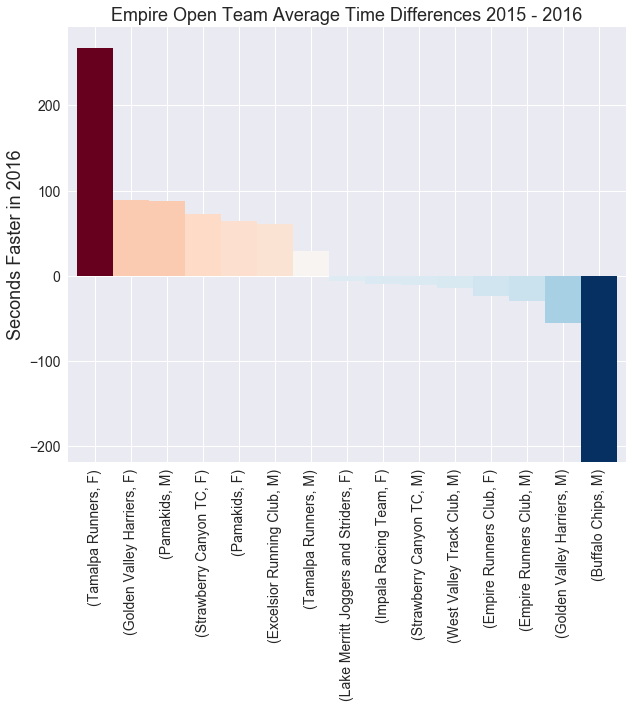

In [22]:
cmap = get_cmap('RdBu')
norm_data = 1-(seconds_faster-seconds_faster.min())/(seconds_faster.max()-seconds_faster.min())
colors = [cmap(pct) for pct in norm_data]

fig, ax = plt.subplots(figsize=(10,8))    
seconds_faster.plot(kind='bar', ax=ax, fontsize=14, color=colors, width=1)
ax.set_title('Empire Open Team Average Time Differences 2015 - 2016',fontsize=18)
ax.set_ylabel('Seconds Faster in 2016', fontsize=18)


Plot age by time for each gender to observe the relationship

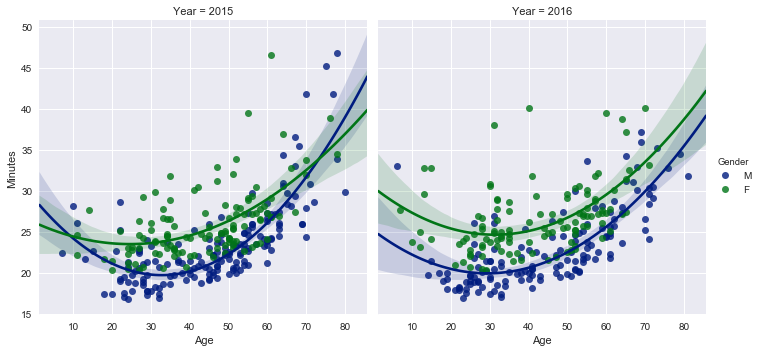

In [23]:
sns.lmplot('Age', 'Minutes', data=df, hue='Gender', order=2, palette='dark', col='Year')
#t=plt.title('Empire Open 5K: Results by Age and Gender', size=12)


In [24]:
import statsmodels.formula.api as smf
model = smf.ols(formula = 'Minutes ~ Age + I(Age**2) + C(Gender) + C(Year)', data = df).fit()
print model.summary()

                            OLS Regression Results                            
Dep. Variable:                Minutes   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     172.4
Date:                Wed, 22 Mar 2017   Prob (F-statistic):           3.69e-95
Time:                        12:27:36   Log-Likelihood:                -1408.5
No. Observations:                 547   AIC:                             2827.
Df Residuals:                     542   BIC:                             2848.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          30.3114      0.970     

In [25]:
#model.predict({'Age':40, 'Gender':'F'})

model.predict({'Age':18, 'Gender':'M', 'Year':2016})


array([ 21.26052302])

In [26]:

res=pd.Series(model.resid,name='Residuals')

In [27]:
#Top 5 performances controlling for age and gender
print df.join(res).sort_values(by='Residuals')[['Name', 'Age', 'Gender', 'Time']][:5]

             Name  Age Gender     Time
286   Len Goldman   71      M 00:24:08
482  Tony Alvarez   80      M 00:29:52
304   Len Goldman   70      M 00:24:20
290    Mo Bartley   60      F 00:24:11
504   Bill Dodson   81      M 00:31:49


In [28]:
top5_resid = df[full_team].join(res).groupby(['Team','Gender','Year'])['Residuals'].nsmallest(5).reset_index()
best_teams = top5_resid.groupby(['Team','Gender','Year'])['Residuals'].sum().unstack()[2016].sort_values()
print best_teams[:3]

Team                    Gender
Tamalpa Runners         M        -21.456713
Impala Racing Team      F        -19.757007
West Valley Track Club  M        -14.611984
Name: 2016, dtype: float64


In [29]:
best_teams.idxmin()

(u'Tamalpa Runners', u'M')

In [30]:
df16=df[df.Year==2016]
print df.set_index(['Team','Gender']).loc[best_teams.idxmin()].reset_index()[:5][['Age','Gender','Time']]

#df.set_index(group_cols).loc[best_teams.idxmin()]

   Age Gender     Time
0   38      M 00:20:03
1   47      M 00:20:20
2   52      M 00:20:22
3   51      M 00:20:23
4   44      M 00:20:44


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  from ipykernel import kernelapp as app


Beautiful Soup is a Python library for pulling data out of HTML and XML files. It works with your favorite parser to provide idiomatic ways of navigating, searching, and modifying the parse tree. It commonly saves programmers hours or days of work.

These instructions illustrate all major features of Beautiful Soup 4, with examples. I show you what the library is good for, how it works, how to use it, how to make it do what you want, and what to do when it violates your expectations.

The examples in this documentation should work the same way in Python 2.7 and Python 3.2.

You might be looking for the documentation for Beautiful Soup 3. If so, you should know that Beautiful Soup 3 is no longer being developed, and that Beautiful Soup 4 is recommended for all new projects. If you want to learn about the differences between Beautiful Soup 3 and Beautiful Soup 4, see Porting code to BS4.

This documentation has been translated into other languages by Beautiful Soup users:



http://savvastjortjoglou.com/nba-draft-part01-scraping.html